# Imports

In [21]:
import pandas as pd
from pathlib import Path

import OAI_Utilities as utils # ln -s ../../OAI/notebooks/OAI_Utilities.py

# Constants

In [22]:
OAI_DATA_PATH = Path.home() / 'code/OAI/notebooks/data/'
idxSlc = pd.IndexSlice

VARIABLES_OF_INTEREST = [
    "(0008, 0070) Manufacturer",
    "(0008, 1090) Manufacturer's Model Name",
    "(0012, 0030) Clinical Trial Site ID",
    "(0018, 1000) Device Serial Number",
]

# Import data

In [23]:
# Read in the dataframes for analysis 
metadata_df = utils.read_parquet(OAI_DATA_PATH / 'dicom_metadata_df.parquet')
allclinical_df = utils.read_parquet(OAI_DATA_PATH / 'allclinical_values.parquet')

xray_df = utils.read_parquet(OAI_DATA_PATH / 'xray_values.parquet')
xray_df = xray_df[xray_df['XRBARCD'] != '']
xray_df = xray_df[xray_df['EXAMTP'] == 'Bilateral PA Fixed Flexion Knee'] # Lets only consider xrays that we might use in the deep learning

enrollees_df = utils.read_parquet(OAI_DATA_PATH / 'enrollees_values.parquet')

/Users/brandong.hill/code/xray_fingerprints/notebooks/OAI_Utilities.py:453: PerformanceWarning: indexing past lexsort depth may impact performance.
  if idx and isinstance(df[col][idx], np.ndarray):


# Create unified dataframe

In [4]:
# Map of patient IDs to barcodes, also drop 4 extraneous digits in barcode
# Result= ID: XRBARCD
barcode_site_id_df = pd.DataFrame(xray_df['XRBARCD'].str[4:].reset_index('Visit'))
print('{:,}'.format(len(barcode_site_id_df)))

# Result= XRBARCD: ID, SITE, RACE, Visit, INCOME, INCOME2, 'COMORB', '(0008, 1090) Manufacturer's Model Name', '(0012, 0030) Clinical Trial Site ID', ....
barcode_site_id_df = barcode_site_id_df.join(enrollees_df[['SITE', 'RACE']], how='left')  # Add hospital site and patient race
barcode_site_id_df = barcode_site_id_df.join(allclinical_df.loc[idxSlc[:, 'V00'], :][['INCOME', 'INCOME2', 'COMORB']].reset_index('Visit', drop=True), on='ID', how='left') # Add starting income and comborbidities
barcode_site_id_df = barcode_site_id_df.reset_index('ID').set_index('XRBARCD')  # Switch to index by barcode
barcode_site_id_df = barcode_site_id_df.join(metadata_df[VARIABLES_OF_INTEREST]) # Add Mfg model, and Clinical Site ID (xray machine location)
print('{:,}'.format(len(barcode_site_id_df)))  # Sanity check, the joins shouldn't be increase the number of entries

26,522
26,522


# Start to look at imbalance across sites

In [5]:
# Is the mfg model a tell as to which site?
tmp = barcode_site_id_df[['SITE', "(0008, 1090) Manufacturer's Model Name"]].groupby('SITE').value_counts()
tmp[tmp > 0]

SITE  (0008, 1090) Manufacturer's Model Name
A     ddR Modulaire System                      2693
      ddR Formula System                        1233
      DigitalDiagnost                             64
      ddR Multi System                            29
      ADC_51xx                                     4
      ddR Combi System                             4
      "Definium 5000"                              2
      ADC_5146                                     2
      digital DIAGNOST                             1
      Lumisys                                      1
      "Thunder Platform"                           1
B     Lumisys                                   1785
                                                 102
C     ADC_5146                                  3936
      "Definium 5000"                           3468
      "Thunder Platform"                         415
D     ADC_51xx                                  4727
      Discovery XR656                            406
E

Absolutely. There is some repetition, but no two sites seem to favor the same models (especially if we consider A & E the same location).

In [6]:
# How many x-rays per site?
barcode_site_id_df.groupby('SITE')['ID'].count()

SITE
A    4040
B    5731
C    7819
D    6628
E    2304
Name: ID, dtype: int64

Notice that if we add A & E their counts are on the same leve as other sites.

In [7]:
# How does race split across sites? Percentages shown.
tmp = barcode_site_id_df[['SITE', 'RACE']].groupby('SITE').value_counts(normalize=True)
tmp = tmp[tmp > 0].apply(lambda x: '{:.1%}'.format(x)).unstack('SITE')
tmp

SITE,A,B,C,D,E
RACE,,,,,
1: White or Caucasian,50.7%,95.1%,91.4%,84.2%,57.0%
2: Black or African American,47.1%,1.7%,7.0%,13.7%,38.8%
0: Other Non-white,1.3%,2.1%,1.2%,0.9%,2.8%
3: Asian,0.6%,0.9%,0.4%,1.2%,1.2%
.R: Refused,0.1%,0.1%,NaN,NaN,NaN
.D: Don t Know/Unknown/Uncertain,0.0%,NaN,0.1%,NaN,0.3%


In [8]:
utils.render_dataframe(tmp, Path('imgs/OAI_site_v_race.svg'))

In [9]:
utils.render_dataframe(tmp, Path('imgs/OAI_site_v_race.docx'))

In [10]:
# Income distribution?
tmp = barcode_site_id_df[['SITE', 'INCOME']].groupby('SITE').value_counts(normalize=True)
tmp = tmp[tmp > 0].apply(lambda x: '{:.1%}'.format(x)).unstack('SITE')
tmp

SITE,A,B,C,D,E
INCOME,,,,,
4: $50K to < $100K,31.4%,33.5%,38.3%,37.2%,28.2%
5: $100K or greater,24.5%,22.6%,30.9%,18.5%,17.1%
3: $25K to < $50K,20.9%,25.3%,19.8%,26.2%,25.1%
2: $10K to < $25K,11.4%,11.3%,4.2%,9.3%,10.0%
.D: Don t Know/Unknown/Uncertain,6.9%,4.1%,4.5%,3.9%,4.4%
1: Less than $10K,3.5%,2.4%,1.5%,2.7%,7.0%
.R: Refused,0.8%,0.3%,0.6%,1.3%,6.8%
.M: Missing,0.6%,0.5%,0.2%,1.0%,1.4%


In [11]:
utils.render_dataframe(tmp, Path('imgs/OAI_site_v_income1.svg'))

In [12]:
# Income distribution (simplified)?
tmp = barcode_site_id_df[['SITE', 'INCOME2']].groupby('SITE').value_counts(normalize=True)
tmp = tmp[tmp > 0].apply(lambda x: '{:.1%}'.format(x)).unstack('SITE')
tmp

SITE,A,B,C,D,E
INCOME2,,,,,
2: > $50K,58.4%,57.8%,72.0%,57.4%,47.6%
1: < $50K,37.0%,39.1%,25.7%,38.3%,43.1%
.D: Don t Know/Unknown/Uncertain,3.4%,2.4%,1.7%,2.7%,3.3%
.R: Refused,0.8%,0.3%,0.3%,1.3%,5.3%
.M: Missing,0.3%,0.3%,0.2%,0.3%,0.7%


In [13]:
utils.render_dataframe(tmp, Path('imgs/OAI_site_v_income2.svg'))

In [14]:
utils.render_dataframe(tmp, Path('imgs/OAI_site_v_income2.docx'))

In [15]:
# Charleson comorbidity scores?  Sicker patients at one site vs another?
# barcode_site_id_df.reset_index().pivot(index='XRBARCD', columns='SITE', values='COMORB').hist(density=True, sharex=True, sharey=True)

array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'B'}>],
       [<Axes: title={'center': 'C'}>, <Axes: title={'center': 'D'}>],
       [<Axes: title={'center': 'E'}>, <Axes: >]], dtype=object)

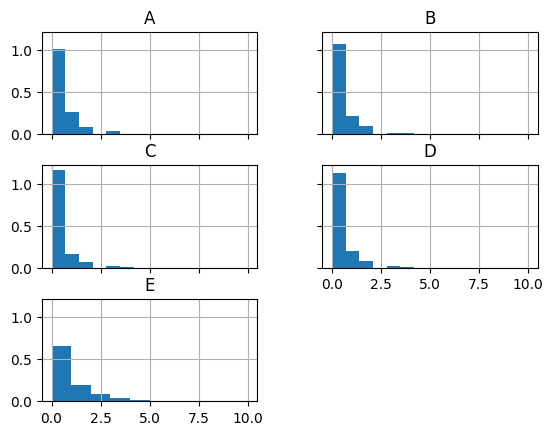

In [16]:
tmp = barcode_site_id_df.reset_index().pivot(index='XRBARCD', columns='SITE', values='COMORB')
for name, col in tmp.items():
    tmp[name] = pd.to_numeric(col)
tmp.hist(density=True, sharex=True, sharey=True)

In [17]:
# Charleson comorbidity scores
tmp = barcode_site_id_df[['SITE', 'COMORB']].groupby('SITE').value_counts(normalize=True)
tmp = tmp[tmp > 0].apply(lambda x: '{:.1%}'.format(x)).unstack('SITE')
tmp.index = tmp.index.rename_categories({x: str(x) for x in range(11)})
tmp

SITE,A,B,C,D,E
COMORB,,,,,
0,71.4%,75.2%,81.3%,79.0%,66.1%
1,18.2%,15.1%,11.9%,13.6%,19.1%
2,6.3%,6.9%,4.5%,5.5%,8.6%
3,3.0%,1.5%,1.5%,1.3%,3.8%
4,0.4%,0.8%,0.4%,0.3%,1.5%
5,0.3%,0.4%,0.1%,0.1%,0.4%
6,0.3%,NaN,0.2%,0.1%,0.4%
7,0.2%,0.1%,0.1%,0.1%,NaN
10,NaN,NaN,NaN,NaN,0.2%


In [18]:
utils.render_dataframe(tmp, Path('imgs/OAI_site_v_CCI.svg'))

In [19]:
utils.render_dataframe(tmp, Path('imgs/OAI_site_v_CCI.docx'))

In [20]:
# Worst health? How many with Comorbidity Score > 1?
tmp = barcode_site_id_df[['SITE', 'COMORB']].groupby('SITE').value_counts(normalize=True) * 100
print((100 - (tmp.loc[idxSlc[:, 0]] + tmp.loc[idxSlc[:, 1]])).to_markdown(tablefmt='mediawiki'))

{| class="wikitable" style="text-align: left;"
|+ <!-- caption -->
|-
! SITE   !! align="right"|        0
|-
| A      || align="right"| 10.4622
|-
| B      || align="right"|  9.64298
|-
| C      || align="right"|  6.81614
|-
| D      || align="right"|  7.35114
|-
| E      || align="right"| 14.8369
|}
